In [1]:
import os
from sys import stdout
from openmm import *
from openmm.app import *
from openmm.unit import *

import nglview as ngl
import pytraj as pt
import numpy as np
import matplotlib.pyplot as plt

# Enhanced sampling with OpenMM and Adaptive Sampling

In this short tutorial we will show how to use the adaptive sampling package together with OpenMM.

We will run test simulations on the mimimal "protein" alanine-dipeptide. Data files for this notebook were taken from the OpenMM test systems.

*    alanine-dipeptide.pdb (All-atom PDB file.)
*    alanine-dipeptide.crd (AMBER input coordinates)
*    alanine-dipeptide.prmtop (AMBER parameters and topology)

A thorough discussion of the alanine dipeptide system can be found [here](https://doi.org/10.1073/pnas.100127697).

For this tutorial we will use the following programm packages:
*    OpenMM for molecular simulation: https://openmm.org/
*    PyTraj for trajectory analysis: https://amber-md.github.io/pytraj/latest/index.html
*    Nglview for molecular visualisation: https://github.com/nglviewer/nglview

In the following we begin with a minimal example of an unbiased OpenMM simulation of alanine dipeptide in vacuum.

In [5]:
def run(nsteps: int=10000, T: float=300.0, dcd_freq: int=10, out_freq: int=10):
    
    # load system topology and coordinates from AMBER format
    prmtop = AmberPrmtopFile(f"../data/alanine-dipeptide.prmtop")
    crd = AmberInpcrdFile(f"../data/alanine-dipeptide.crd")

    # create the system and integrator 
    system = prmtop.createSystem(
        nonbondedMethod=NoCutoff,
    )
    platform = Platform.getPlatformByName('CPU')
    integrator = LangevinIntegrator(T * kelvin, 1.0 / picoseconds, 2.0 * femtosecond)

    # setup an simulation and run MD for nsteps
    simulation = Simulation(prmtop.topology, system, integrator, platform)
    simulation.context.setPositions(crd.positions)
    simulation.context.setVelocitiesToTemperature(T)
    simulation.reporters.append(DCDReporter('alanine-dipeptide-test.dcd', dcd_freq))
    simulation.reporters.append(StateDataReporter(
        stdout, 
        out_freq,
        step=True,
        time=True,
        potentialEnergy=True,
        kineticEnergy=True,
        totalEnergy=True,
        temperature=True,
        separator='\t')
    )
    simulation.step(nsteps)

In [6]:
run(nsteps=100)

#"Step"	"Time (ps)"	"Potential Energy (kJ/mole)"	"Kinetic Energy (kJ/mole)"	"Total Energy (kJ/mole)"	"Temperature (K)"
10	0.020000000000000004	-50.79755386981094	70.55110334121584	19.753549471404895	269.37610634002436
20	0.04000000000000002	-44.51712296338454	61.19730951885241	16.68018655546787	233.66173136860365
30	0.06000000000000004	-51.781119699499385	67.1487266032733	15.367606903773918	256.3852535458994
40	0.08000000000000006	-51.004304765162814	71.17157318264597	20.167268417483157	271.74516567531924
50	0.10000000000000007	-57.730534155959944	71.80545693673349	14.074922780773548	274.1654416095234
60	0.12000000000000009	-55.12567375368214	67.37304245530504	12.247368701622896	257.2417296029557
70	0.1400000000000001	-61.65763606175986	75.85806710184093	14.200431040081071	289.6389961691285
80	0.16000000000000011	-38.61553150499074	58.99410856671861	20.378577061727867	225.24953558620655
90	0.18000000000000013	-27.811395073005883	57.134041610464095	29.322646537458212	218.14748373332134


We can visualize the trajectory using pytraj and nglview. 

Alanine dipeptide is a popular testsystem for enhanced sampling algorithms because it is a minimal example for sampling challanges that are posed by many biological systems. The slow motions of the molecule are largely governed by the $\psi$ (backbone N-C-C-N) and $\phi$ (backbone C-N-C-C) diherals. Below atoms involved in this collective variables (CVs) are shown in ball and stick representation, while other atoms are transperent.  

In [7]:
traj = pt.iterload("alanine-dipeptide-test.dcd", top="../data/alanine-dipeptide.pdb")

view = ngl.show_pytraj(traj)
view.clear_representations()
view.add_ball_and_stick('@6,8,14,16', opacity=1.0) # CV atoms of phi torsion
view.add_ball_and_stick('@4,6,8,14', opacity=1.0)  # CV atoms of psi torsion
#view.add_ball_and_stick('@1,4,6,8', opacity=1.0)   # CV atoms of theta torsion

view.add_licorice(opacity=0.5)
view

NGLWidget(max_frame=9)

# Enhanced sampling of $\psi$ with WTM-eABF

In the following example we will apply the WTM-eABF sampling algorithm to enhance sampling along the $\psi$ angle. Note, that this is a suboptimal CV and there is still an orthogonal free energy barrier along the $\phi$ torsion. 

In [9]:
from adaptive_sampling.sampling_tools import *
from adaptive_sampling.interface.interface_openmm import AdaptiveSamplingOpenMM

# ------------------------------------------------------------------------------------
# define collective variables
cv_atoms_psi    = [5, 7, 13, 15]  # backbone N-C-C-N torsion
cv_atoms_phi    = [3, 5, 7, 13]   # backbone C-N-C-C torsion
minimum         = -180.0          # minimum of the CV
maximum         = 180.0           # maximum of the CV
bin_width       = 5.0             # bin with along the CV

collective_var_psi = [["torsion", cv_atoms_psi, minimum, maximum, bin_width]]
#collective_var_phi = [["torsion", cv_atoms_phi, minimum, maximum, bin_width]]

# ------------------------------------------------------------------------------------
# Setup OpenMM
prmtop = AmberPrmtopFile(f"alanine-dipeptide.prmtop")
crd = AmberInpcrdFile(f"alanine-dipeptide.crd")
system = prmtop.createSystem(
    nonbondedMethod=NoCutoff,
    constraints=HBonds,
)

# remove center of mass motion
cmm_force = CMMotionRemover()
cmm_force.setFrequency(10)
system.addForce(cmm_force)

# Initialize the `AdaptiveSamplingOpenMM` interface to couple the OpenMM simulaiton to an bias potential
# the Openmm `simulation` object is set up internally, but can still be modified by calling `the_md.simulation`
the_md = AdaptiveSamplingOpenMM(
    crd.positions,
    prmtop.topology,
    system,
    dt=2.0,                                       # timestep in fs
    equil_temp=300.0,                             # temperature of simulation
    langevin_damping=1.0,                         # langevin damping in 1/ps
    cv_atoms=np.unique(cv_atoms_phi+cv_atoms_psi) # specifying CV atoms significantly speeds up the simulation, as the bias force will only be calculated for those
)
the_md.integrator.setConstraintTolerance(0.0001)

# Append OpenMM reporters to simulation for output 
the_md.simulation.reporters.append(DCDReporter('alanine-dipeptide.dcd', 100))
the_md.simulation.reporters.append(StateDataReporter(
    stdout, 
    1000,
    step=True,
    time=True,
    potentialEnergy=True,
    kineticEnergy=True,
    totalEnergy=True,
    temperature=True,
    speed=False,
    separator='\t')
)

# --------------------------------------------------------------------------------------
# Setup the sampling algorithm
eabf_ext_sigma    = 5.0     # thermal width of coupling between CV and extended variable 
eabf_ext_mass     = 100.0   # mass of extended variable 
abf_nfull         = 500     # number of samples per bin when abf force is fully applied
mtd_hill_height   = 0.1     # MtD hill height    
mtd_hill_std      = 15.0    # MtD hill width
mtd_well_tempered = 1000.0  # Well-tempered temperature
mtd_frequency     = 100     # frequency of hill creation

the_bias = WTMeABF(
    eabf_ext_sigma, 
    eabf_ext_mass, 
    mtd_hill_std,
    mtd_hill_std,
    the_md, 
    collective_var_psi, 
    output_freq=1000, 
    f_conf=0.0, 
    nfull=abf_nfull,
    equil_temp=300.0,
    well_tempered_temp=mtd_well_tempered,
    hill_drop_freq=mtd_frequency,
    force_from_grid=True,
    kinetics=True,
    verbose=False,
)

the_md.set_sampling_algorithm(the_bias)

ModuleNotFoundError: No module named 'adaptive_sampling.interface.interface_openmm'

In [10]:
# Warning: this may take a while!
if True:
    os.system("rm CV_traj.dat wtmeabf.out")
the_md.run(nsteps=10000) # 500000 * 2 fs = 1 ns

rm: das Entfernen von 'CV_traj.dat' ist nicht möglich: Datei oder Verzeichnis nicht gefunden
rm: das Entfernen von 'wtmeabf.out' ist nicht möglich: Datei oder Verzeichnis nicht gefunden


NameError: name 'the_md' is not defined

# Basic Analysis of Results 

In [27]:
traj = pt.iterload("alanine-dipeptide.dcd", top="alanine-dipeptide.pdb")

In [28]:
traj = pt.iterload("alanine-dipeptide.dcd", top="alanine-dipeptide.pdb")

view = ngl.show_pytraj(traj)
view.clear_representations()
view.add_ball_and_stick('@6,8,14,16', opacity=1.0) # CV atoms of phi torsion
view.add_ball_and_stick('@4,6,8,14', opacity=1.0)  # CV atoms of psi torsion
#view.add_ball_and_stick('@1,4,6,8', opacity=1.0)   # CV atoms of theta torsion

view.add_licorice(opacity=0.5)
view

NGLWidget(max_frame=99)

### 

In [29]:
cv_traj = np.loadtxt('CV_traj.dat', skiprows=1, usecols=[0,1,2,3,4])

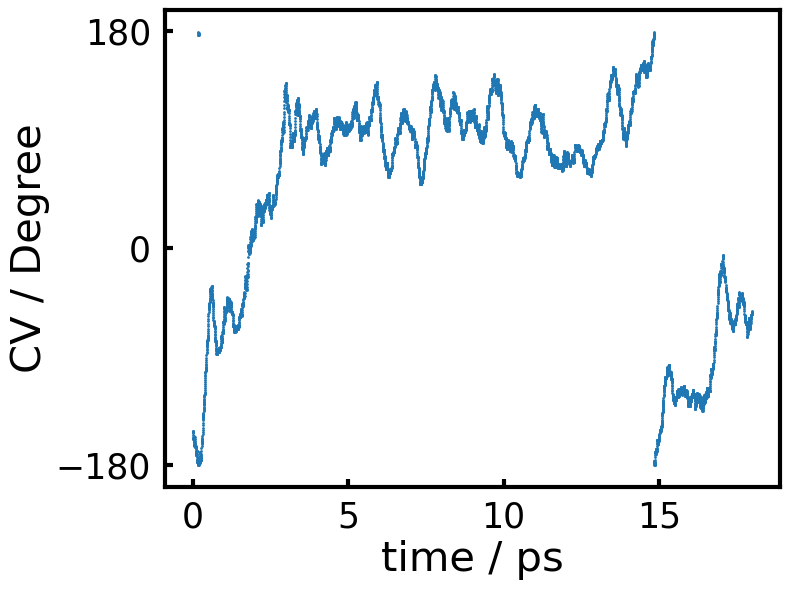

In [30]:
fig, axs = plt.subplots(1, 1, sharey=False, figsize=(8,6))
axs.scatter(cv_traj[:,0]/1000, cv_traj[:,1], s=1)
axs.set_yticks([-180,0,180])
axs.set_xlabel('time / ps', fontsize=30)
axs.set_ylabel('CV / Degree', fontsize=30)
axs.tick_params(axis='y',length=6,width=3,labelsize=25, pad=10, direction='in')
axs.tick_params(axis='x',length=6,width=3,labelsize=25, pad=10, direction='in')
axs.spines['bottom'].set_linewidth(3)
axs.spines['top'].set_linewidth(3)
axs.spines['left'].set_linewidth(3)
axs.spines['right'].set_linewidth(3)
fig.tight_layout()

# Use the MBAR estimator to compute ensamble properties

Now we will use the MBAR estimator to calculate the unbiased weights of simulation frames. From those we compute an periodic PMF along the \psi or \phi angle.

In [12]:
from adaptive_sampling.processing_tools import mbar
ext_sigma = 5.0    # thermal width of coupling between CV and extended variable 

# grid for free energy profile can be different than during sampling
minimum   = -180.0    
maximum   = 180.0    
bin_width = 5.0  
grid = np.arange(minimum, maximum, bin_width)

cv = cv_traj[:,1]  # trajectory of collective variable
la = cv_traj[:,2]  # trajectory of extended system

# run MBAR and compute free energy profile and probability density from statistical weights
traj_list, indices, meta_f = mbar.get_windows(grid, cv, la, ext_sigma, equil_temp=300.0)

exp_U, frames_per_traj = mbar.build_boltzmann(
    traj_list, 
    meta_f, 
    equil_temp=300.0,
    periodicity=[-180.0,180.0],
)

weights = mbar.run_mbar(
    exp_U,
    frames_per_traj,
    max_iter=10000,
    conv=1.0e-4,
    conv_errvec=1.0,
    outfreq=100,
    device='cpu',
)

pmf_mbar, rho_mbar = mbar.pmf_from_weights(grid, cv[indices], weights, equil_temp=300.0)

Start of the self-consistent iteration.
Iter    1:	Conv=  0.5393468098	Conv_errvec=   2026.691073
Iter  100:	Conv=  0.0214242692	Conv_errvec=    189.147900
Iter  200:	Conv=  0.0147109615	Conv_errvec=     90.586868
Iter  300:	Conv=  0.0083323403	Conv_errvec=     49.469389
Iter  400:	Conv=  0.0046424875	Conv_errvec=     27.417317
Iter  500:	Conv=  0.0025863407	Conv_errvec=     15.325135
Iter  600:	Conv=  0.0014417138	Conv_errvec=      8.603788
Iter  700:	Conv=  0.0008041087	Conv_errvec=      4.823601
Iter  800:	Conv=  0.0004486980	Conv_errvec=      2.701687
Iter  900:	Conv=  0.0002504697	Conv_errvec=      1.512193
Iter 1000:	Conv=  0.0001398558	Conv_errvec=      0.846010
Converged after 1058 iterations!
Max error vector:       0.603965


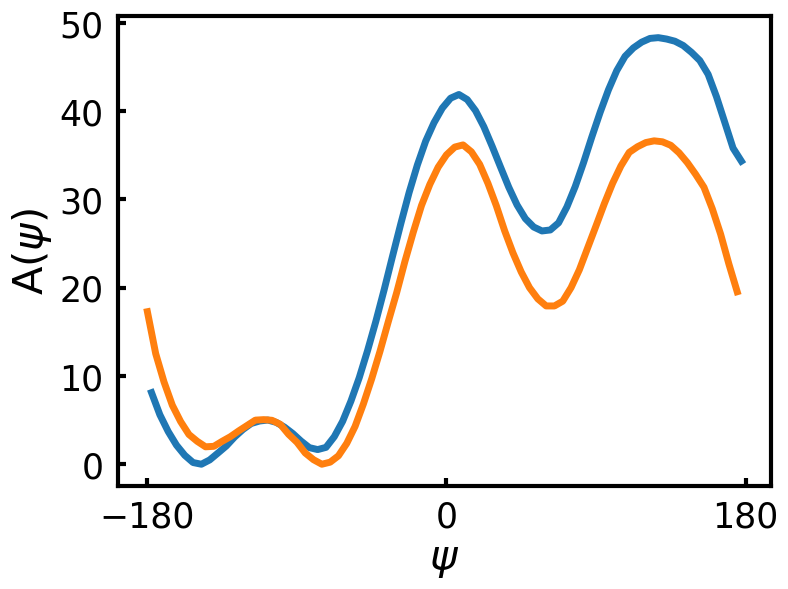

In [13]:
fig, axs = plt.subplots(1, 1, sharey=False, figsize=(8,6))
#plt.plot(np.degrees(the_bias.grid[0]), the_bias.pmf[0], linewidth=5)
plt.plot(grid, pmf_mbar-pmf_mbar.min(), linewidth=5)

axs.set_xlabel(r'$\psi$', fontsize=30)
axs.set_ylabel(r'A($\psi$)', fontsize=30)
axs.set_xticks([-180,0,180])
axs.tick_params(axis='y',length=6,width=3,labelsize=25, pad=10, direction='in')
axs.tick_params(axis='x',length=6,width=3,labelsize=25, pad=10, direction='in')
axs.spines['bottom'].set_linewidth(3)
axs.spines['top'].set_linewidth(3)
axs.spines['left'].set_linewidth(3)
axs.spines['right'].set_linewidth(3)
fig.tight_layout()

# Plot samples along Ramadachan Angles

In [14]:
phi, psi = pt.multidihedral(traj, 'phi psi')

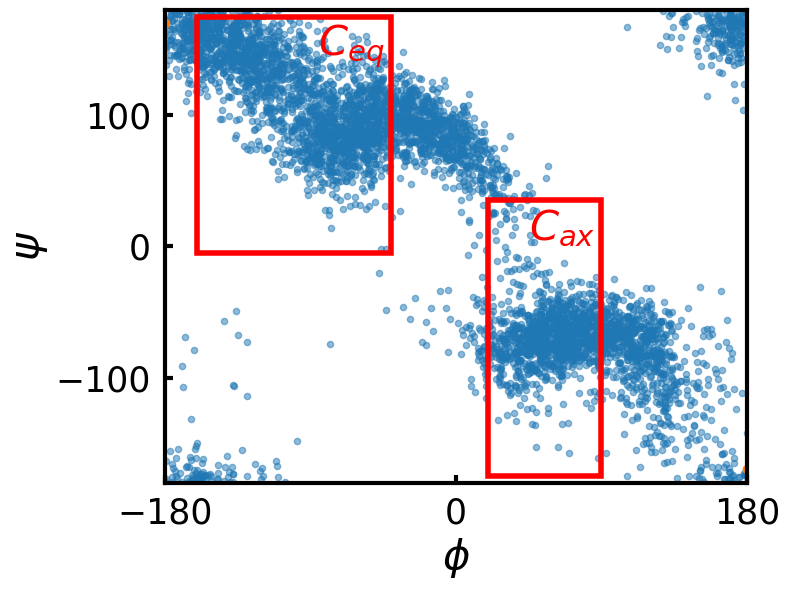

In [28]:
from matplotlib.patches import Rectangle
fig, axs = plt.subplots(1, 1, sharey=False, figsize=(8,6))

axs.scatter(phi, psi, alpha=0.5, s=20)

# markup minima
fontdict = {'family': 'serif', 'color':  'red', 'weight': 'normal', 'size': 30,}
axs.add_patch(Rectangle((-160,-5),120,180, edgecolor='red', facecolor='none', lw=4))
axs.add_patch(Rectangle((20,-175),70,210, edgecolor='red', facecolor='none', lw=4))
axs.text(-85,145,r'$C_{eq}$', fontdict=fontdict)
axs.text(45,5,r'$C_{ax}$', fontdict=fontdict)

# formatting
axs.set_xlabel(r'$\phi$', fontsize=fontdict['size'])
axs.set_ylabel(r'$\psi$', fontsize=fontdict['size'])
axs.set_xlim([-180,180])
axs.set_ylim([-180,180])
axs.set_xticks([-180,0,180])
axs.tick_params(axis='y',length=6,width=3,labelsize=25, pad=10, direction='in')
axs.tick_params(axis='x',length=6,width=3,labelsize=25, pad=10, direction='in')
axs.spines['bottom'].set_linewidth(3)
axs.spines['top'].set_linewidth(3)
axs.spines['left'].set_linewidth(3)
axs.spines['right'].set_linewidth(3)
fig.tight_layout()